# Load Data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [2]:
import os
import sys

INGESTION_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, INGESTION_PATH)

from ingestion import fetch
from ingestion import config
from product import plotting_functions


In [3]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date

## Load Data

In [4]:
data_path = Path("../data/landing/311-service-requests")

lf = pl.scan_parquet(
    str(data_path / "**/*.parquet"),
    hive_partitioning=True,
)

## Subset Data to DOHMH

In [5]:
# Filter for DOHMH agency and add derived columns
dohmh_data_only = lf.filter(pl.col("agency") == "DOHMH").select([
    "due_date",
    "landmark",
    "intersection_street_1",
    "intersection_street_2",
    "facility_type",
    "cross_street_2",
    "cross_street_1",
    "bbl",
    "location_type",
    "street_name",
    "incident_address",
    "address_type",
    "longitude",
    "latitude",
    "x_coordinate_state_plane",
    "y_coordinate_state_plane",
    "city",
    "incident_zip",
    "resolution_description",
    "closed_date",
    "resolution_action_updated_date",
    "descriptor",
    "community_board",
    "park_borough",
    "borough",
    "unique_key",
    "created_date",
    "agency_name",
    "agency",
    "complaint_type",
    "status",
    "open_data_channel_type",
    "park_facility_name",
    "year",
    "month"
]).collect()

df_orig = dohmh_data_only.to_pandas()

In [6]:
df_orig['date'] = df_orig['created_date'].dt.date

df_orig['time_to_resolution'] = df_orig['closed_date'] - df_orig['created_date']
df_orig['time_closed_to_resolution_update'] = df_orig['resolution_action_updated_date'] - df_orig['closed_date']
df_orig['closed_before_created'] = df_orig['time_to_resolution'] < pd.Timedelta(0)
df_orig['identical_created_closed_dates'] = df_orig['time_to_resolution'] == pd.Timedelta(0)
df_orig['created_at_midnight'] = df_orig['created_date'].dt.time == pd.Timestamp('00:00:00').time()
df_orig['closed_at_midnight'] = df_orig['closed_date'].dt.time == pd.Timestamp('00:00:00').time()

In [7]:
df_orig = df_orig[df_orig['closed_before_created'] == 0]
df_orig = df_orig[df_orig['identical_created_closed_dates'] == 0]



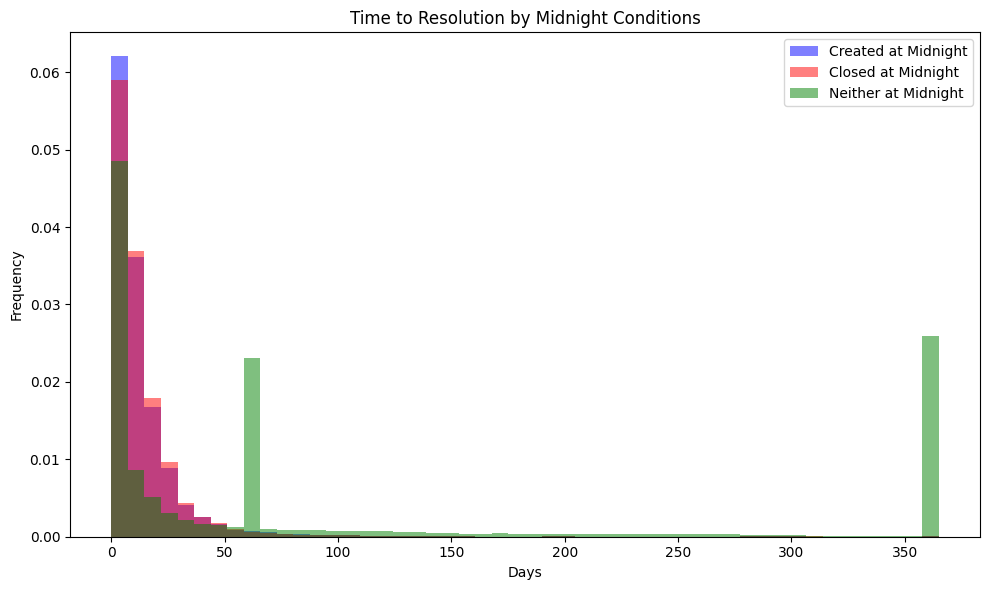

Created at Midnight - Count: 240539
Closed at Midnight - Count: 179181
Neither at Midnight - Count: 571653


In [8]:
# Create subsets based on midnight conditions
created_midnight = df_orig[df_orig['created_at_midnight'] == True]
closed_midnight = df_orig[df_orig['closed_at_midnight'] == True]
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]

# Create single histogram with all three distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert time_to_resolution to days for better visualization
created_midnight_days = created_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
closed_midnight_days = closed_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
neither_midnight_days = neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)

created_midnight_days = created_midnight_days.clip(upper = 365)
closed_midnight_days = closed_midnight_days.clip(upper = 365)
neither_midnight_days = neither_midnight_days.clip(upper = 365)

# Plot all histograms on the same axes
ax.hist(created_midnight_days, bins=50, alpha=0.5, color='blue', label='Created at Midnight', density= True)
ax.hist(closed_midnight_days, bins=50, alpha=0.5, color='red', label='Closed at Midnight', density= True)
ax.hist(neither_midnight_days, bins=50, alpha=0.5, color='green', label='Neither at Midnight', density= True)

ax.set_title('Time to Resolution by Midnight Conditions')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Created at Midnight - Count:", len(created_midnight))
print("Closed at Midnight - Count:", len(closed_midnight))
print("Neither at Midnight - Count:", len(neither_midnight))


In [9]:
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]

neither_midnight['time_to_resolution_days_rounded'] = (neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)).round(0)

neither_midnight['time_to_resolution_days_rounded'].value_counts()

C:\Users\gorav\AppData\Local\Temp\ipykernel_11168\1428400437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neither_midnight['time_to_resolution_days_rounded'] = (neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)).round(0)


time_to_resolution_days_rounded
1.0       51329
61.0      43108
0.0       42549
60.0      28282
2.0       20093
          ...  
2343.0        1
2183.0        1
2293.0        1
2212.0        1
2193.0        1
Name: count, Length: 2393, dtype: int64

In [10]:
neither_midnight = neither_midnight[neither_midnight['time_to_resolution_days_rounded'].isin([60, 61])]

neither_midnight['complaint_type'].value_counts()

complaint_type
Food Establishment                63614
Mobile Food Vendor                 3194
Smoking or Vaping                  2808
Non-Residential Heat                885
Rodent                              234
Indoor Air Quality                  148
Tattooing                           139
Poison Ivy                           90
Standing Water                       50
Indoor Sewage                        48
Unsanitary Animal Pvt Property       29
Drinking Water                       21
Asbestos                             20
Mold                                 18
Unleashed Dog                        16
Mosquitoes                           14
Smoking                              14
Beach/Pool/Sauna Complaint           10
Day Care                              8
Unsanitary Pigeon Condition           6
Food Poisoning                        5
Calorie Labeling                      5
Lifeguard                             3
Illegal Animal Kept as Pet            3
Animal Facility - No Perm

In [11]:
neither_midnight['complaint_type'].value_counts()


complaint_type
Food Establishment                63614
Mobile Food Vendor                 3194
Smoking or Vaping                  2808
Non-Residential Heat                885
Rodent                              234
Indoor Air Quality                  148
Tattooing                           139
Poison Ivy                           90
Standing Water                       50
Indoor Sewage                        48
Unsanitary Animal Pvt Property       29
Drinking Water                       21
Asbestos                             20
Mold                                 18
Unleashed Dog                        16
Mosquitoes                           14
Smoking                              14
Beach/Pool/Sauna Complaint           10
Day Care                              8
Unsanitary Pigeon Condition           6
Food Poisoning                        5
Calorie Labeling                      5
Lifeguard                             3
Illegal Animal Kept as Pet            3
Animal Facility - No Perm

In [12]:
neither_midnight['month'].value_counts()


month
7     7437
4     7081
6     7080
5     6766
3     6330
1     6095
8     5608
2     5400
12    5110
9     5017
11    4756
10    4710
Name: count, dtype: int64

In [13]:
(neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)).value_counts()

time_to_resolution
60.017118    14
60.012373    13
60.004363    13
60.001238    12
60.017743    12
             ..
60.782500     1
60.731181     1
60.471169     1
60.450093     1
60.434572     1
Name: count, Length: 41851, dtype: int64

In [14]:
neither_midnight[neither_midnight['complaint_type'] == 'Food Establishment']['resolution_description'].value_counts()

resolution_description
The Department of Health and Mental Hygiene has sent official written notification to the Owner/Landlord warning them of potential violations and instructing them to correct the situation.  If the situation persists 21 days after your initial complaint, please make a new complaint.                                                                                                                                                                                                                         55897
The NYC Health Department has responded to your service request.  Restaurant inspection information can be found online at www.nyc.gov/health/abceats. This service request has been closed.                                                                                                                                                                                                                                                                                            

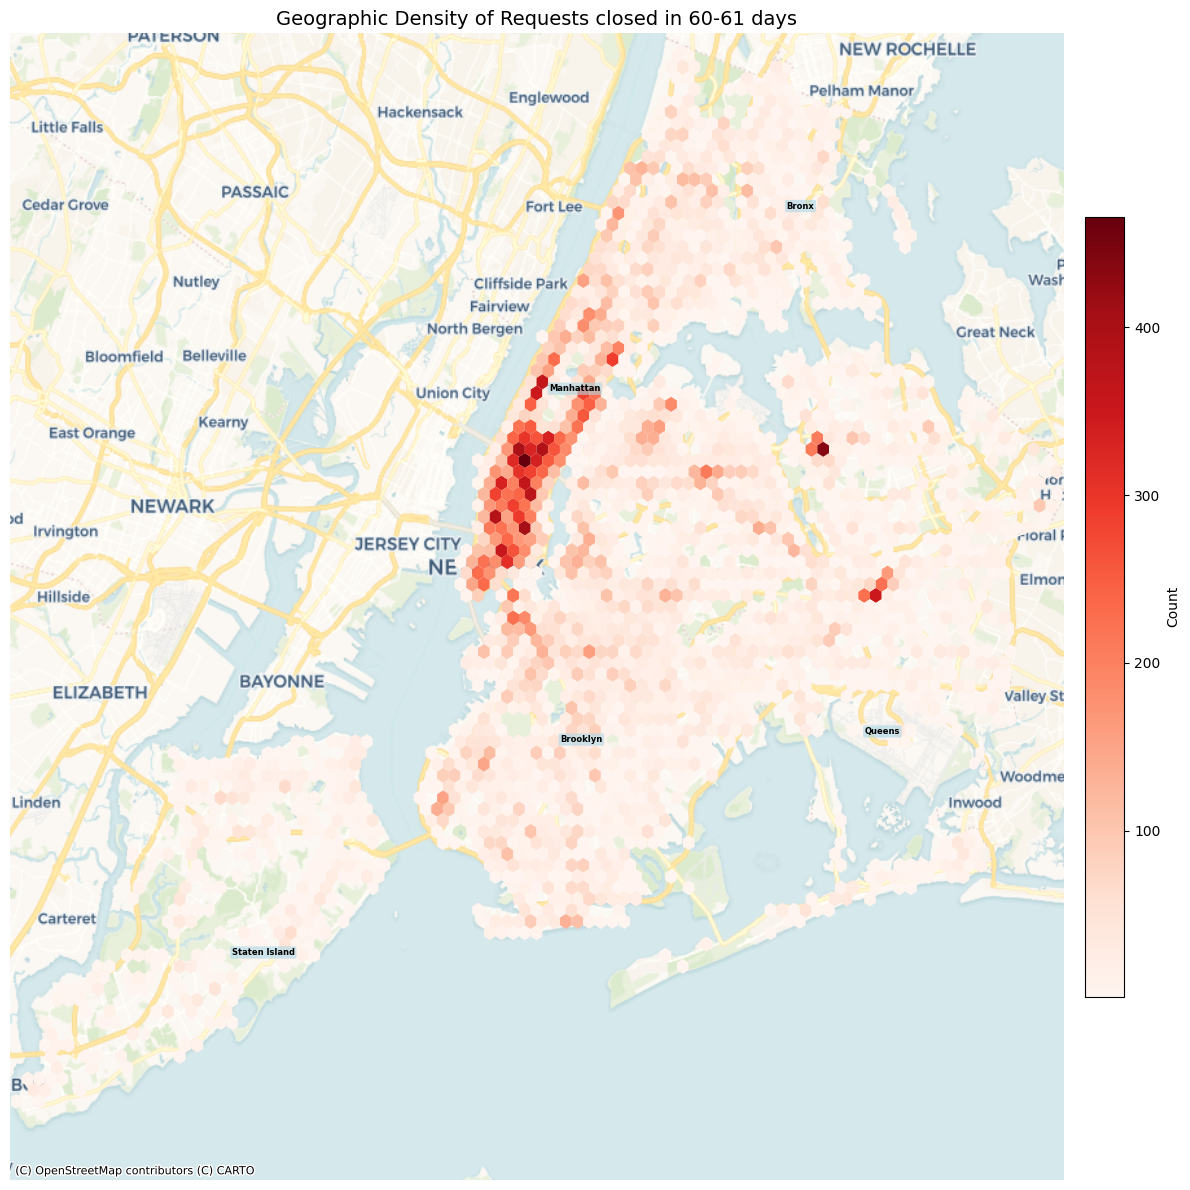

In [16]:
# Example usage with the existing data
fig, ax = plotting_functions.create_hexbin_density_map(
    neither_midnight, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests closed in 60-61 days",
)
plt.show()


## Merge Census Data

In [ ]:
data_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "acs-population", "combined_population_data.csv"))
df_pop = pd.read_csv(data_path)
df_pop['GEOID'] = df_pop['GEOID'].astype(str)


In [ ]:
bg_shapefile = os.path.abspath(os.path.join(INGESTION_PATH, 'resources', "tl_2022_36_bg"))  # replace with your path
gdf_bg = gpd.read_file(bg_shapefile)

In [ ]:
geometry = [Point(xy) for xy in zip(df_orig.longitude, df_orig.latitude)]
gdf_orig = gpd.GeoDataFrame(df_orig, geometry=geometry, crs="EPSG:4326")

gdf_bg = gdf_bg.to_crs("EPSG:4326")  # make sure CRS matches
gdf_orig_bg = gpd.sjoin(gdf_orig, gdf_bg[['GEOID', 'geometry']], how="left")

df_orig_merged = gdf_orig_bg.merge(df_pop, on=['GEOID', 'year'], how='left')


### Merge Weather Data

In [ ]:
data_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "noaa-nclimgrid-daily", "nyc_fips_weather_data.csv"))
df_weather = pd.read_csv(data_path)
df_weather['fips'] = df_weather['fips'].astype(str)
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date

In [ ]:
df_orig_merged['fips'] = df_orig_merged['GEOID'].apply(lambda x: str(x)[:5])
df_orig_merged = df_orig_merged.merge(df_weather[['fips', 'date', 'tmax', 'tmin', 'tavg', 'prcp']], on = ['fips', 'date'], how = 'left')

In [ ]:
df_weather.groupby(['fips', 'year', 'month'])['month'].count()

In [ ]:
df_orig_merged